In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
# libraries
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from keras.applications.nasnet import NASNetLarge,preprocess_input
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
train_path = "/content/gdrive/MyDrive/Kaggle/dogs_classification/imgs/"
test_path = "/content/gdrive/MyDrive/Kaggle/dogs_classification/imgs_validation/"

In [ ]:
# class sayısını almak için yaptık trainpath içine gir /* ==> hepsini al
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  120


In [ ]:
img_height,img_widght=(331,331)
batch_size = 128

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   validation_split=0.2,
                   shear_range = 0.3,
                   horizontal_flip=True,
                   zoom_range = 0.4)


# test verilerini normalize ettik 
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# train kısmı
''' train_datagen.flow_from_directory()
    ile alırsa pathi (uzantıyı) düzgün verildiğinde dosya isimleri class ve içerisinde görseller
    var ise otomatik bir şekilde okuyabiliyor.
    her dosyayı class olarak ayırıyor ve onları depoluyor 
'''
'''
x.shape[:2] (x,y) boyutlarını alıyor sadece 
yaparsak rgb kısmını almasına gerek kalmıyor
'''
# color_mode = rgb olduğu için rgb yazıyoruz
validation_generator= train_datagen.flow_from_directory(
        train_path, 
        target_size=(img_height,img_widght),
        batch_size = batch_size,
        color_mode='rgb',
        class_mode= "categorical",
        subset="validation")

train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size=(img_height,img_widght),
        batch_size = batch_size,
        color_mode='rgb',
        class_mode= "categorical",
        subset="training")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size=(img_height,img_widght),
        batch_size = 1,
        color_mode='rgb',
        class_mode= "categorical")

Found 3832 images belonging to 120 classes.
Found 15548 images belonging to 120 classes.
Found 1200 images belonging to 120 classes.


In [ ]:
import keras
base_model= NASNetLarge(include_top=False,weights="imagenet")
x= base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation="relu")(x)
x = Dropout(0.5)(x)
predictions= Dense(numberOfClass,activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layers in base_model.layers:
    layers.trainable = False

model.compile(loss = "categorical_crossentropy",
              optimizer = Adam(lr=0.001),
              metrics = ["accuracy"])
model.summary()
print(len(model.layers))

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='dog.{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
hist = model.fit(train_generator,
                           epochs=40,
                           validation_data=validation_generator,
                           callbacks=my_callbacks)

Epoch 1/40
122/122 [==============================] - 740s 6s/step - loss: 1.3398 - accuracy: 0.7501 - val_loss: 0.3050 - val_accuracy: 0.9136
Epoch 2/40
122/122 [==============================] - 695s 6s/step - loss: 0.3005 - accuracy: 0.9135 - val_loss: 0.3079 - val_accuracy: 0.9139
Epoch 3/40
122/122 [==============================] - 691s 6s/step - loss: 0.2652 - accuracy: 0.9221 - val_loss: 0.3115 - val_accuracy: 0.9154
Epoch 4/40
122/122 [==============================] - 692s 6s/step - loss: 0.2411 - accuracy: 0.9262 - val_loss: 0.3016 - val_accuracy: 0.9165
Epoch 5/40
122/122 [==============================] - 691s 6s/step - loss: 0.2545 - accuracy: 0.9230 - val_loss: 0.3271 - val_accuracy: 0.9175
Epoch 6/40
122/122 [==============================] - 691s 6s/step - loss: 0.2347 - accuracy: 0.9294 - val_loss: 0.3137 - val_accuracy: 0.9139
Epoch 7/40
122/122 [==============================] - 694s 6s/step - loss: 0.2204 - accuracy: 0.9304 - val_loss: 0.3268 - val_accuracy: 0.9162

1200


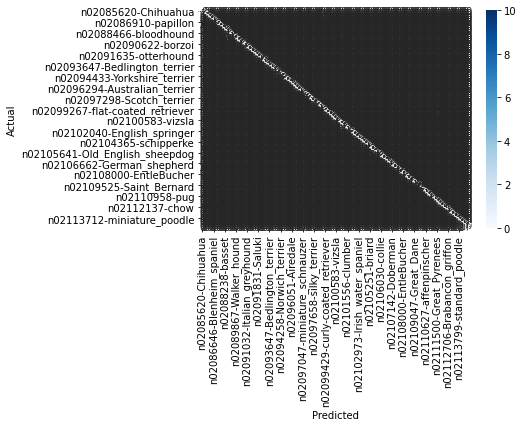

test accuracy : 94.33333333333334


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import tensorflow as tf
filenames = test_generator.filenames
nb_samples = len(test_generator)
print(nb_samples)
y_pred=[]
y_act=[]
test_generator.reset()

for i in range(nb_samples):
  x_test,y_test = test_generator.next()
  y_pred.append(model.predict(x_test))
  y_act.append(y_test)

predict_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_pred]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]
out_df = pd.DataFrame(np.vstack([predict_class,actual_class]).T,columns=['predicted_class','actual_class'])
cm = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(cm,cmap='Blues',annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(cm).sum()/cm.sum().sum()*100)))

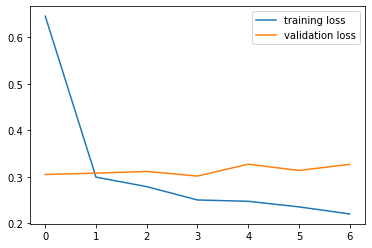

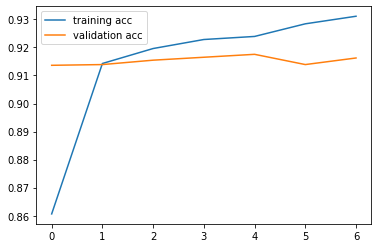

In [ ]:
plt.plot(hist.history["loss"],label = "training loss")
plt.plot(hist.history["val_loss"],label = "validation loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(hist.history["accuracy"],label = "training acc")
plt.plot(hist.history["val_accuracy"],label = "validation acc")
plt.legend()
plt.show()

        NASNetLarge => test accuracy : 94.33333333333334